In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, extract, cast

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
m_columns = inspector.get_columns('measurement')
s_columns = inspector.get_columns('station')

print('[measurement table]')
for c in m_columns:
    print(c['name'], c["type"])
print('------------')  
print('[station table]')
for c in s_columns:
    print(c['name'], c["type"])

[measurement table]
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
[station table]
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(earliest_date)
print(latest_date)

('2010-01-01',)
('2017-08-23',)


In [13]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date:", one_year_ago)

Query Date: 2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, 
       func.sum(Measurement.prcp)]

monthly_sum = session.query(*sel).\
                filter(func.strftime('%Y', Measurement.date)).\
                filter(Measurement.date <= '2017-08-23').\
                filter(Measurement.date >= '2016-08-23').\
                group_by(Measurement.date).\
                order_by(Measurement.date).all()

monthly_sum_df = pd.DataFrame(monthly_sum, columns = ['date', 'prcp_sum'])
monthly_sum_df.head()

,date,prcp_sum
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32


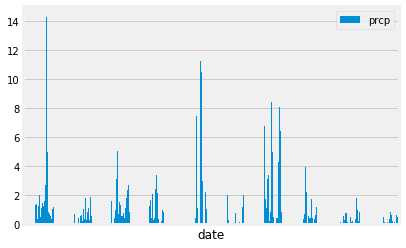

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Use Pandas Plotting with Matplotlib to plot the data

m_df = pd.DataFrame(monthly_sum, columns = ['date', 'prcp'])
m_df.set_index('date', inplace=True)

m_df.plot.bar()
# plt.tight_layout()
plt.xticks([])
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
m_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [17]:
# Design a query to show how many stations are available in this dataset
session.query(Measurement.station).group_by(Measurement.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()

print(active_stations)
active_stations_df = pd.DataFrame(active_stations, columns = ['station_id', 'tobs_count'])
active_stations_df.head(10)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


,station_id,tobs_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_tobs = session.query(Measurement.date, Measurement.station, func.count(Measurement.tobs), func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()

print(station_tobs)
station_tobs_df = pd.DataFrame(station_tobs, columns = ['date', 'station_id', 'tobs_count','tobs_min','tobs_max','tobs_avg'])
station_tobs_df.head(10)

[('2015-09-10', 'USC00519281', 2772, 54.0, 85.0, 71.66378066378067), ('2010-08-23', 'USC00519397', 2724, 56.0, 87.0, 74.55323054331865), ('2014-09-14', 'USC00513117', 2709, 59.0, 85.0, 72.68918420081211), ('2017-08-19', 'USC00519523', 2669, 56.0, 85.0, 74.5436493068565), ('2013-10-13', 'USC00516128', 2612, 58.0, 84.0, 70.91500765696784), ('2015-08-29', 'USC00514830', 2202, 58.0, 85.0, 74.8732970027248), ('2010-09-19', 'USC00511918', 1979, 53.0, 87.0, 71.61596766043456), ('2017-07-03', 'USC00517948', 1372, 58.0, 87.0, 74.68440233236151), ('2010-09-27', 'USC00518838', 511, 58.0, 83.0, 72.72407045009784)]


,date,station_id,tobs_count,tobs_min,tobs_max,tobs_avg
0,2015-09-10,USC00519281,2772,54.0,85.0,71.663781
1,2010-08-23,USC00519397,2724,56.0,87.0,74.553231
2,2014-09-14,USC00513117,2709,59.0,85.0,72.689184
3,2017-08-19,USC00519523,2669,56.0,85.0,74.543649
4,2013-10-13,USC00516128,2612,58.0,84.0,70.915008
5,2015-08-29,USC00514830,2202,58.0,85.0,74.873297
6,2010-09-19,USC00511918,1979,53.0,87.0,71.615968
7,2017-07-03,USC00517948,1372,58.0,87.0,74.684402
8,2010-09-27,USC00518838,511,58.0,83.0,72.724070


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_tobs = session.query(Measurement.date, Measurement.tobs).\
                filter(func.strftime('%m', Measurement.date)).\
                filter(Measurement.date <= '2017-08-23').\
                filter(Measurement.date >= '2016-08-23').\
                filter(Measurement.station == 'USC00519281').\
                order_by(Measurement.date).all()

most_tobs_df = pd.DataFrame(most_tobs, columns = ['date','tobs_count'])
most_tobs_df.head()

,date,tobs_count
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


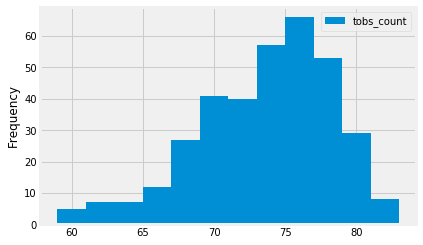

In [21]:
tobs_df = pd.DataFrame(most_tobs, columns = ['date', 'tobs_count'])
tobs_df.set_index('date', inplace=True)

ax = tobs_df.plot.hist(bins=12, alpha=1)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
